# Jupyter Notebook: Analysing Trump Twitter Data 

This Jupyter Notebook is an extension to the tutorial on analysing Trump tweets using Python which will soon be available at [infowissblog.de/index.php/tutorial-tweets-analysieren-mit-python](https://www.infowissblog.de/index.php/tutorial-tweets-analysieren-mit-python). For any problems/questions you can contact me via [Twitter](https://twitter.com/bibwiss) or [contact form](https://infowissblog.de/en/index.php/kontakt/).

## Preperation and Data Cleaning

* import modules
* read json file into pandas dataframe
* clean data from all kinds of retweets
* transform col `created_at` into recognizable format and extract year as extra column

In [1]:
#import all necessary modules

# general
import json
import pandas as pd

#numbers and time
import numpy as np
from collections import Counter
from datetime import datetime

# text
import re #regular expressions
import preprocessor as p #from tweet-preprocessor library, see https://pypi.org/project/tweet-preprocessor/
from textblob import TextBlob #text processing library, here used to extract sentiment, see also https://textblob.readthedocs.io/en/dev/
from nltk import ngrams

#stats
from scipy import stats
import researchpy as rp

# visualizations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.colors import n_colors
import seaborn as sn


In [2]:
#read json file

with open("dataset_media.json", 'r',encoding="utf8") as f:
        datastore = json.load(f)

# convert json to dataframe

df = pd.json_normalize(datastore)
df

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,RT @WhiteHouse: LIVE: President @realDonaldTru...,Mon Aug 03 21:36:46 +0000 2020,4971,0,True,1290401249251270663
1,Twitter for iPhone,My visits last week to Texas and Florida had m...,Mon Aug 03 15:27:41 +0000 2020,24241,111167,False,1290308363872538624
2,Twitter for iPhone,RT @realDonaldTrump: FAKE NEWS IS THE ENEMY OF...,Mon Aug 03 13:53:10 +0000 2020,78121,0,True,1290284578578419712
3,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,Mon Aug 03 12:57:35 +0000 2020,15131,72174,False,1290270589945430016
4,Twitter for iPhone,My visits last week to Texas and Frorida had m...,Mon Aug 03 12:46:02 +0000 2020,12976,59426,False,1290267685117460481
...,...,...,...,...,...,...,...
4238,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,Wed Feb 10 15:17:56 +0000 2010,7,1,False,8905123688
4239,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",Tue Jan 12 18:05:08 +0000 2010,20,3,False,7677152231
4240,Twitter Web Client,Reminder: The Miss Universe competition will b...,Sun Aug 23 21:12:37 +0000 2009,1,4,False,3498743628
4241,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,Fri Aug 21 14:32:45 +0000 2009,1,3,False,3450626731


In [3]:
# manually clean data from retweets

# first, check for obvious retweets (in seperate column)
without_RT = df["is_retweet"]==False
df_without_RT = df[without_RT]

# look for retweets within text, initiated by "RT"
df_without_RT["is_rt"] = df["text"].map(lambda x: "true" if x.startswith("RT") else "false") 

# clean dataset again from the remaining retweets previously identified
without_RT_2 = df_without_RT["is_rt"]=="false"
df_without_RT = df_without_RT[without_RT_2]
df_without_RT

# Trump also "cites" tweets by other users (tweets by specific source/common practice?), so these need to be deleted as well 

df_without_RT["is_rt_2"] = df["text"].map(lambda x: "true" if x.startswith("\"@") else "false") 

without_RT_3 = df_without_RT["is_rt_2"]=="false"
df_without_RT = df_without_RT[without_RT_3]
df_without_RT

# now, all of the cols used for cleaning the data from retweets can be deleted as well, since they're no longer relevant
df_media = df_without_RT.drop(columns=["is_retweet", "is_rt", "is_rt_2"])


In [4]:
# transform col "created_at" into recognizable UTC time values as dates/date type
# see also https://stackoverflow.com/questions/7703865/going-from-twitter-date-to-python-datetime-date

# define function, using datetime module
def change_dates(dataframe, index):
    for tweet in dataframe:
        dataframe.iloc[index] = datetime.strftime(datetime.strptime(dataframe.iloc[index],'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')
        index += 1

# call function for col "created_at"
change_dates(df_media["created_at"], 0)


In [5]:
# add extra col containing the year (although this is a very simple way of discretizing the time stamps, better would be something like time series analysis/linear regression)

df_media["year"] = 0 #create new col "year"

#define function similar to the one above to extract the year from "created_at" col
def get_year(dataframe, col, index):
    for tweet in col:
        dataframe.year.iloc[index] = int(datetime.strftime(datetime.strptime(col.iloc[index],'%Y-%m-%d %H:%M:%S'), '%Y'))
        index += 1

# call get_year()
get_year(df_media, df_media["created_at"], 0)
df_media


,source,text,created_at,retweet_count,favorite_count,id_str,year
1,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020
3,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020
4,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020
5,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020
6,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020
...,...,...,...,...,...,...,...
4238,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010
4239,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010
4240,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009
4241,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009


## Text Preprocessing

* manually extract hashtags and mentions using regular expressions
* preprare tweet texts for further analysis

In [6]:
# search for hashtags and mentions, put them in own columns

#hashtags
hashtag_re = re.compile("#(\w+)")
df_media['hashtags'] = np.where(df_media.text.str.contains(hashtag_re), df_media.text.str.findall(hashtag_re), "")

#mentions
mention_re = re.compile("@(\w+)")
df_media['mentions'] = np.where(df_media.text.str.contains(mention_re), df_media.text.str.findall(mention_re), "")

df_media


,source,text,created_at,retweet_count,favorite_count,id_str,year,hashtags,mentions
1,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020,,
3,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020,,"[JoeNBC, foxandfriends, CNN]"
4,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020,,
5,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,,
6,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020,,
...,...,...,...,...,...,...,...,...,...
4238,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010,,
4239,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010,,
4240,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009,,
4241,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009,,


In [7]:
# clean the text from noise (mentions, hashtags, urls, stopwords?) using the preprocessor library

df_media['cleaned_text'] = df_media["text"] #copy col text to cleaned_text

p.set_options(p.OPT.HASHTAG, p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION) #set options for cleaning: clean text from hashtags, mentions, urls and emojis

# define function clean_text() which will append the predefined options to each row
def clean_text(dataframe, index):
    for row in dataframe:
        dataframe.iloc[index] = p.clean(dataframe.iloc[index])
        index += 1

# call clean_text() for col "cleaned_text"
clean_text(df_media["cleaned_text"], 0)
df_media


,source,text,created_at,retweet_count,favorite_count,id_str,year,hashtags,mentions,cleaned_text
1,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020,,,My visits last week to Texas and Florida had m...
3,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020,,"[JoeNBC, foxandfriends, CNN]",Wow! Really bad TV Ratings for Morning Joe ()....
4,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020,,,My visits last week to Texas and Frorida had m...
5,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,,,FAKE NEWS IS THE ENEMY OF THE PEOPLE!
6,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020,,,With the exception of New York &amp; a few oth...
...,...,...,...,...,...,...,...,...,...,...
4238,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010,,,Donald Trump appearing today on CNN Internatio...
4239,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010,,,"Celebrity Apprentice returns to NBC, Sunday, 3..."
4240,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009,,,Reminder: The Miss Universe competition will b...
4241,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009,,,Watch the Miss Universe competition LIVE from ...


## Sentiment Analysis

In [8]:
#sentiment analysis using the python library textblob

#create df containing polarity values for each tweet in the dataset

tweet_text = [] # create an empty list

for index, col in df_media.iterrows(): 
    tweet_text.append(df_media.cleaned_text[index]) # append each tweet to it

sentiment_objects = [TextBlob(tweet) for tweet in tweet_text] # apply textblob for each tweet in tweet_text

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects] # create a new list of polarity values and tweet text

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"]) # transform list into dataframe and sort the values accordingly
sentiment_df.sort_values("polarity", ascending=True)


,polarity,tweet
1756,-1.0,find the leakers within the FBI itself. Classi...
2119,-1.0,"FMR PRES of Mexico, Vicente Fox horribly used ..."
2620,-1.0,If you look at the horrible picture on the fro...
2908,-1.0,The media is pathetic. Our embassies are savag...
1316,-1.0,Some people HATE the fact that I got along wel...
...,...,...
472,1.0,"Triggered, a great book by my son, Don. Now nu..."
972,1.0,Great news!
969,1.0,Finally great news at the Border!
1501,1.0,"Great news, as a result of our TAX CUTS &amp; ..."


In [9]:
# show only VERY BAD, VERY GOOD tweets
very_bad = sentiment_df.loc[sentiment_df['polarity'] == -1.0]
very_good = sentiment_df.loc[sentiment_df['polarity'] == 1.0]

# to analyze the polarity in combination with other values, we append it as an extra column to our earlier dataframe
df_media = df_media.reset_index(drop=True)
df_media['sentiment_values'] = pd.Series(sentiment_df['polarity'])
df_media


,source,text,created_at,retweet_count,favorite_count,id_str,year,hashtags,mentions,cleaned_text,sentiment_values
0,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020,,,My visits last week to Texas and Florida had m...,-0.146429
1,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020,,"[JoeNBC, foxandfriends, CNN]",Wow! Really bad TV Ratings for Morning Joe ()....,0.105078
2,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020,,,My visits last week to Texas and Frorida had m...,-0.146429
3,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,,,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,-0.625000
4,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020,,,With the exception of New York &amp; a few oth...,0.004072
...,...,...,...,...,...,...,...,...,...,...,...
3080,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010,,,Donald Trump appearing today on CNN Internatio...,0.000000
3081,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010,,,"Celebrity Apprentice returns to NBC, Sunday, 3...",0.750000
3082,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009,,,Reminder: The Miss Universe competition will b...,0.136364
3083,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009,,,Watch the Miss Universe competition LIVE from ...,0.136364


In [10]:
#add another col for sentiments

df_media["sentiment"] = "" # new col

# define function to devide sentiment_values into sentiments ("negative","neutral","positive")
def get_sentiment(dataframe, index):
    for tweet in dataframe:
        if df_media.sentiment_values.iloc[index] <= -0.33:
            df_media.sentiment.iloc[index] = "negative"
        elif (df_media.sentiment_values.iloc[index] > -0.33) & (df_media.sentiment_values.iloc[index] <=0.33):
            df_media.sentiment.iloc[index] = "neutral"
        else:
            df_media.sentiment.iloc[index] = "positive"
        index += 1

# apply get_sentiment()
get_sentiment(df_media["sentiment_values"], 0)
df_media


,source,text,created_at,retweet_count,favorite_count,id_str,year,hashtags,mentions,cleaned_text,sentiment_values,sentiment
0,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020,,,My visits last week to Texas and Florida had m...,-0.146429,neutral
1,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020,,"[JoeNBC, foxandfriends, CNN]",Wow! Really bad TV Ratings for Morning Joe ()....,0.105078,neutral
2,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020,,,My visits last week to Texas and Frorida had m...,-0.146429,neutral
3,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,,,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,-0.625000,negative
4,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020,,,With the exception of New York &amp; a few oth...,0.004072,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
3080,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010,,,Donald Trump appearing today on CNN Internatio...,0.000000,neutral
3081,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010,,,"Celebrity Apprentice returns to NBC, Sunday, 3...",0.750000,positive
3082,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009,,,Reminder: The Miss Universe competition will b...,0.136364,neutral
3083,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009,,,Watch the Miss Universe competition LIVE from ...,0.136364,neutral


## Data Analysis

### Descriptive Statistics

* get general summary statistics by using `pd.Dataframe.min()/max()/mean()/std()`
* create visualizations to demonstrate distribution
    * histogram
    * boxplot
    * sunburst chart (`hashtags`)
    * bar chart (`mentions`)

In [11]:
# define function get_statistics() to get min, max, mean and sd
def get_statistics(df_column):
    #print("Minimum: " + str(df_column.min()))
    #print("Maximum: " + str(df_column.max()))
    #print("Mean: " + str(df_column.mean()))
    #print("Standard Deviation: " + str(df_column.std()))
    print(df_column.describe())

#call function on different cols within df
get_statistics(df_media["sentiment_values"])


count    3085.000000
mean        0.050396
std         0.333855
min        -1.000000
25%        -0.131500
50%         0.000000
75%         0.233333
max         1.000000
Name: sentiment_values, dtype: float64


In [12]:
#counting number of unique values in one column

df_media['favorite_count'].nunique() 

2616

#### Histogram

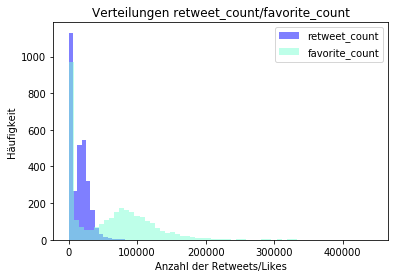

In [13]:
# combined histogram retweet_count/favorite_count

# plot data
fig, ax = plt.subplots()
ax.hist(df_media.retweet_count, color = "blue", alpha=0.5, bins=20)
ax.hist(df_media.favorite_count, color = "aquamarine", alpha=0.5, bins=60)

# add labels, title, legend
ax.set_ylabel('Häufigkeit')
ax.set_xlabel('Anzahl der Retweets/Likes')
ax.set_title(r'Verteilungen retweet_count/favorite_count')
ax.legend()

#show plot
plt.show()

# save figure in high resolution
#fig.savefig('hist_retweet_favorite.png', format='png', dpi=1200)

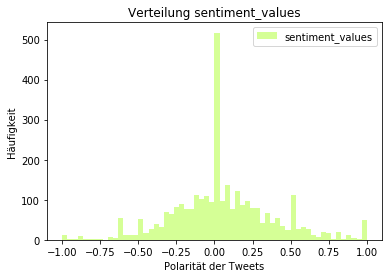

In [14]:
# histogram sentiment_values

data = df_media.sentiment_values

# plot data
fig, ax = plt.subplots()
ax.hist(data, color = "GreenYellow", alpha=0.5, bins=60)

# add labels, title, legend
ax.set_ylabel('Häufigkeit')
ax.set_xlabel('Polarität der Tweets')
ax.set_title(r'Verteilung sentiment_values')
ax.legend()

# show plot
plt.show()

# save figure in high resolution
#fig.savefig('hist_sentiment.png', format='png', dpi=1200)


#### Boxplot

In [15]:
# boxplot favorite_count
data = df_media.favorite_count

# plot
fig = go.Figure()
fig.add_trace(go.Box(y=data, name="favorite_count", marker_color="lightseagreen", boxpoints="all", jitter=0.6,
    pointpos=-2, marker=dict(opacity=0.5), marker_size=5, width=40))

# update layout
fig.update_layout(width=400, height=800, font=dict(color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=3), yaxis=dict(gridcolor = "#ededed", gridwidth=3))

#show plot
fig.show()

In [16]:
# boxplot favorite_count
data = df_media.retweet_count

# plot
fig = go.Figure()
fig.add_trace(go.Box(y=data, name="retweet_count", marker_color="blue", boxpoints="all", jitter=0.6, pointpos=-2, marker=dict(opacity=0.4), marker_size=5, width=40))

# update layout
fig.update_layout(width=400, height=800, font=dict(color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=3), yaxis=dict(gridcolor = "#ededed", gridwidth=3))

# show plot
fig.show()

In [17]:
# boxplot favorite_count
data = df_media.sentiment_values

# plot
fig = go.Figure()
fig.add_trace(go.Box(y=data, name="sentiment_values", marker_color="YellowGreen", boxpoints="all", jitter=0.6, pointpos=-2, marker=dict(opacity=0.4), marker_size=5, width=40,))

# update layout
fig.update_layout(width=400, height=800, font=dict(color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=3), yaxis=dict(gridcolor = "#ededed", gridwidth=3))

# show plot
fig.show()


#### Sunburst Chart (`Hashtags`)

In [18]:
hashtags = [] # create empty list

# iterate through all hashtags and append them to list
for index, col in df_media.iterrows():
    hashtags.append(df_media.hashtags[index])

# transform nested list into flat list
# see https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

flat_list = []
for sublist in hashtags:
    for item in sublist:
        item = item.lower()
        flat_list.append(item)

# clean hashtags from numbers - these are just short versions of "number 1"/"number 2" and not intended to be hashtags

for i in flat_list: 
    if (i == "1") or (i == "2"): 
        flat_list.remove(i)
    if i == "1":
        flat_list.remove(i)
    if i == "2":
        flat_list.remove(i)

# create dict for hashtags by counting occurences of each item, then transform hashtags and frequencies into a dataframe (hashtags_df)
hashtags_dict = Counter(flat_list)
hashtags_df = pd.DataFrame(list(hashtags_dict.items()),columns = ["hashtag", "frequency"]) 

# sort hashtags in descending order
hashtags_df = hashtags_df.sort_values(by="frequency", ascending=False).reset_index(drop=True)

# append heuristically defined categories (see below, "mapping of topics") to cols
hashtags_df["category"] = ["wahlkampf", "wahlkampf", "medienkritik", "show","wahlkampf", "show", "medienkritik", "sonstiges", "show", "sonstiges", "wahlkampf", "wahlkampf", "show", "wahlkampf", "wahlkampf", "wahlkampf", "medien", "wahlkampf", "wahlkampf","medien","medien", "show","medien","medien", "politisches","wahlkampf","medien","medien","medien","medien","medien","medien","medien","wahlkampf","politisches","sonstiges","sonstiges","wahlkampf","medien","politisches","wahlkampf","politisches","wahlkampf","medien","politisches","wahlkampf","politisches","medienkritik","show","medien","sonstiges","politisches","sonstiges","politisches","medienkritik","politisches","medienkritik","politisches","medien","politisches","politisches","show","medienkritik","politisches","wahlkampf","wahlkampf","wahlkampf","medienkritik","wahlkampf","show"]

hashtags_df

,hashtag,frequency,category
0,trump2016,22,wahlkampf
1,maga,20,wahlkampf
2,fakenews,12,medienkritik
3,celebapprentice,9,show
4,makeamericagreatagain,7,wahlkampf
...,...,...,...
65,americafirst,1,wahlkampf
66,crookedhillary,1,wahlkampf
67,frozen,1,medienkritik
68,littlemarco,1,wahlkampf


mapping of topics:

|hashtags|categories|
|---|---|
|trump2016|wahlkampf
|maga|wahlkampf
|fakenews|medienkritik
|celebapprentice|show
|makeamericagreatagain|wahlkampf
|celebrityapprentice|show
|fake|medienkritik
|timetogettough|sonstiges
|missuniverse|(tv-)show
|icymi|sonstiges
|draintheswamp|wahlkampf
|gopdebate|wahlkampf
|missusa|show
|supertuesday|wahlkampf
|kag|wahlkampf
|votetrump|wahlkampf
|abc2020|medien
|imwithyou|wahlkampf
|fitn|wahlkampf
|fox|medien
|kimmel|medien
|meetthetrumps|show
|mediabuzz|medien
|periscope|medien
|taxreform|politisches
|kag2020|wahlkampf
|trumptuesday|medien
|media|medien
|roadhard|medien
|colbert|medien
|lssc|medien
|nbc|medien
|trumpvlog|medien
|iacaucus|wahlkampf
|ted |politisches
|savethequeen|sonstiges
|mssng|sonstiges
|letsmakeamericagreatagain|wahlkampf
|cnn|medien
|isis|politisches
|votetrumpsc|wahlkampf
|justiceact|politisches
|votetrumpil|wahlkampf
|rogerstone|medien
|usmca|politisches
|electionnight|wahlkampf
|protectkavanaugh|politisches
|fakenewscnn|medienkritik
|snhuarena|show
|socialmediasummit|medien
|salutetoamerica|sonstiges
|demdebate|politisches
|hurricanemichael|sonstiges
|natosummit2018|politisches
|stopthebias|medienkritik
|g7summit|politisches
|fraudnewscnn|medienkritik
|kateslaw|politisches
|amazonwashingtonpost|medien
|dow|politisches
|nasdaq|politisches
|superbowl|show
|riggedsystem|medienkritik
|failing|politisches
|debates2016|wahlkampf
|americafirst|wahlkampf
|crookedhillary|wahlkampf
|frozen|medienkritik
|littlemarco|wahlkampf
|sweepstweet|show  


In [19]:
# create sunburst chart vis to give a simple idea of how the distribution looks like 

# plot
fig = px.sunburst(hashtags_df, path=["category", "hashtag"], values='frequency', color="frequency", color_continuous_scale=[[0,"white"],[1.0, "blue"]])

# update layout
fig.update_layout(width=900, height=900, uniformtext=dict(minsize=13, mode='hide'),coloraxis_showscale=False) # labels of hashtags with frequency=1 are not shown (by "minsize=13, mode='hide'")

# show plot
fig.show()
#fig.write_html("path/to/file.html")

#### Bar Chart (`Mentions`)

In [20]:
mentions = [] # create empty list

# iterate through all mentions and append them to list
for index, col in df_media.iterrows():
    mentions.append(df_media.mentions[index])

# change nested list to flat list
# see https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

flat_list = []
for sublist in mentions:
    for item in sublist:
        item = item.lower()
        flat_list.append(item)


# create dict for mentions by counting occurences of each item, then transform mentions and frequencies into a dataframe (mentions_df)
mentions_dict = Counter(flat_list)
mentions_df = pd.DataFrame(list(mentions_dict.items()),columns = ["mention", "frequency"]) 

# sort mentions in descending order 
mentions_df = mentions_df.sort_values(by="frequency", ascending=False).reset_index(drop=True)
        
mentions_df

,mention,frequency
0,cnn,258
1,nytimes,179
2,foxnews,127
3,nbc,84
4,foxandfriends,43
...,...,...
433,deptvetaffairs,1
434,greta,1
435,shopfloornam,1
436,senatemajldr,1


In [21]:
# bar chart showing the top 10 mentions and their frequencies

data = mentions_df.iloc[:11]

# plot
fig = px.bar(data, x="mention", y="frequency")
fig.update_traces(marker_color='lightseagreen', opacity=.6, texttemplate='%{y}', textposition='outside')

# update layout
fig.update_layout(width=800, height=500, font=dict(size=12, color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=1), yaxis=dict(gridcolor = "#ededed", gridwidth=1))

# show plot
fig.show()

### Relationships Between Variables

* nominal (Chi-Square/Cramers V/Contingency Table)
* metric (Pearson) + ordinal (Spearman/Kendall = rank correlation)
* visualizations: scatter plots


#### Chi-Square/Cramers V/Contingency Table (`source` x `year`)

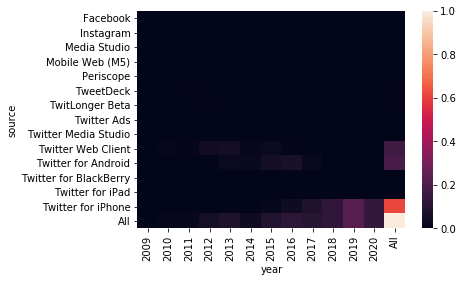

In [22]:
#contingency table for source x year

x = pd.crosstab(index=df_media['source'], columns=df_media['year'], margins=True).applymap(lambda r: r/len(df_without_RT))

sn.heatmap(x, annot=False)
plt.show()

In [23]:
# crosstab, res, expected = rp.crosstab(df_media.source, df_media.year,prop="cell",test="chi-square",correction=True, cramer_correction=True, expected_freqs=True)
# expected

# since a lot of the expected frequencies are less than 5 the chi square test is not applicable here -> leave out "smaller" values for "source" & "year" == 2009 (since their has not been that much activity in this year - only 3 tweets)


df_source_year = df_media[["source", "year"]]

# define rows that should be deleted and drop() them
delete_sources = ["Facebook","Instagram","Media Studio", "Mobile Web (M5)", "Periscope", "TweetDeck", "TwitLonger Beta", "Twitter Ads", "Twitter Media Studio", "Twitter for BlackBerry", "Twitter for iPad"]

for i in delete_sources:
    index_source = df_source_year[ (df_source_year["source"] == i)].index
    df_source_year.drop(index_source , inplace=True)

# drop rows for year == 2009
index_source = df_source_year[ (df_source_year["year"] == 2009)].index
df_source_year.drop(index_source , inplace=True)

# get another chi-square test
crosstab, res, expected = rp.crosstab(df_source_year.source, df_source_year.year,prop="cell",test="chi-square",correction=True, cramer_correction=True, expected_freqs=True)

res


,Chi-square test,results
0,Pearson Chi-square ( 20.0) =,3236.3409
1,p-value =,0.0000
2,Cramer's V =,0.7328


#### Pearson / Spearman / Kendall

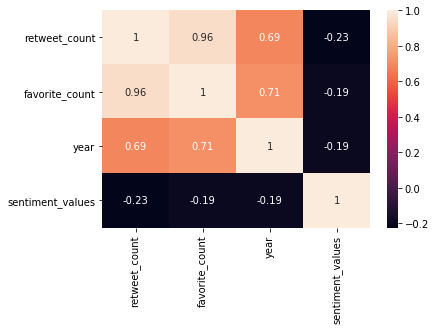

In [24]:
# heatmap showing correlations of different metric variables in dataset
# see also https://datatofish.com/correlation-matrix-pandas/

corrMatrix = df_media.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [25]:
#covariance
df_media.cov()

,retweet_count,favorite_count,year,sentiment_values
retweet_count,1.863120e+08,7.575518e+08,24888.146746,-1028.823542
favorite_count,7.575518e+08,3.373330e+09,109055.876564,-3694.134808
year,2.488815e+04,1.090559e+05,6.940225,-0.170913
sentiment_values,-1.028824e+03,-3.694135e+03,-0.170913,0.111459


In [26]:

#correlation using researchpy, change method to "pearson"/"spearman"/"kendall"
rp.corr_pair(df_media[["retweet_count","favorite_count"]], method="kendall")

,r value,p-value,N
retweet_count & favorite_count,0.8794,0.0000,3085


#### Visualizations

this can be adjusted by simple copy+pasting and changing the variable, so there is just one example below; all other visualizations can be found in the repository (`daa_2020/visualizations`)

In [27]:
# scatterplot

df = df_media

# plot
fig = px.scatter(df, x="created_at", y="source",color="sentiment_values", color_continuous_scale=["orangered","greenyellow","blue"], opacity=.5)

# update layout
fig.update_layout(font=dict(size=12, color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=2), yaxis=dict(gridcolor = "#ededed", gridwidth=2), width=1200)

# show plot
fig.show()

### Inductive Analysis

In [28]:
# copy df for this step, it gets messy
# df_media should stay as it is (deep=True)
df_ngrams = df_media.copy(deep=True)

#create a new column "ngrams"
df_ngrams["ngrams"] = ""

#def function to iterate through df and get all 5-grams within "cleaned_text"
def get_ngrams(dataframe, index):
    for tweet in dataframe:
        list_ngrams = []
        n = 5
        fivegrams = list(ngrams(df_ngrams.cleaned_text.iloc[index].split(), n))
        dataframe.iloc[index] = fivegrams
        index += 1

# call get_ngrams()
get_ngrams(df_ngrams["ngrams"], 0)

df_ngrams

,source,text,created_at,retweet_count,favorite_count,id_str,year,hashtags,mentions,cleaned_text,sentiment_values,sentiment,ngrams
0,Twitter for iPhone,My visits last week to Texas and Florida had m...,2020-08-03 15:27:41,24241,111167,1290308363872538624,2020,,,My visits last week to Texas and Florida had m...,-0.146429,neutral,"[(My, visits, last, week, to), (visits, last, ..."
1,Twitter for iPhone,Wow! Really bad TV Ratings for Morning Joe (@J...,2020-08-03 12:57:35,15131,72174,1290270589945430016,2020,,"[JoeNBC, foxandfriends, CNN]",Wow! Really bad TV Ratings for Morning Joe ()....,0.105078,neutral,"[(Wow!, Really, bad, TV, Ratings), (Really, ba..."
2,Twitter for iPhone,My visits last week to Texas and Frorida had m...,2020-08-03 12:46:02,12976,59426,1290267685117460481,2020,,,My visits last week to Texas and Frorida had m...,-0.146429,neutral,"[(My, visits, last, week, to), (visits, last, ..."
3,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,,,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,-0.625000,negative,"[(FAKE, NEWS, IS, THE, ENEMY), (NEWS, IS, THE,..."
4,Twitter for iPhone,With the exception of New York &amp; a few oth...,2020-08-03 11:46:24,22738,97890,1290252674777133057,2020,,,With the exception of New York &amp; a few oth...,0.004072,neutral,"[(With, the, exception, of, New), (the, except..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,Twitter Web Client,Donald Trump appearing today on CNN Internatio...,2010-02-10 15:17:56,7,1,8905123688,2010,,,Donald Trump appearing today on CNN Internatio...,0.000000,neutral,"[(Donald, Trump, appearing, today, on), (Trump..."
3081,Twitter Web Client,"Celebrity Apprentice returns to NBC, Sunday, 3...",2010-01-12 18:05:08,20,3,7677152231,2010,,,"Celebrity Apprentice returns to NBC, Sunday, 3...",0.750000,positive,"[(Celebrity, Apprentice, returns, to, NBC,), (..."
3082,Twitter Web Client,Reminder: The Miss Universe competition will b...,2009-08-23 21:12:37,1,4,3498743628,2009,,,Reminder: The Miss Universe competition will b...,0.136364,neutral,"[(Reminder:, The, Miss, Universe, competition)..."
3083,Twitter Web Client,Watch the Miss Universe competition LIVE from ...,2009-08-21 14:32:45,1,3,3450626731,2009,,,Watch the Miss Universe competition LIVE from ...,0.136364,neutral,"[(Watch, the, Miss, Universe, competition), (t..."


In [29]:
# delete cols "hashtags"/"mentions", they cannot be analysed anymore due to deletion of duplicates
df_ngrams = df_ngrams.drop(columns=["hashtags","mentions"])

df_ngrams.ngrams.astype(str)


# for further ngram analysis, split up the listed ngrams into seperate rows similar to the explode() function
# explode does not work here, it resolves all nested listed, but here only the first level needs to be resolved

#gladly found the following function online: https://github.com/cognoma/genes/blob/721204091a96e55de6dcad165d6d8265e67e2a48/2.process.py#L61-L95

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

# call function tidy_split() and separate all ngrams per tweet from each other
df_grams = tidy_split(df_ngrams,"ngrams",sep="), (")


In [30]:
#as a last step, clean them from final remains

df_grams.ngrams = df_grams.ngrams.replace({'\[\(':''}, regex=True)
df_grams.ngrams = df_grams.ngrams.replace({'\)\]':''}, regex=True)
df_grams.ngrams = df_grams.ngrams.replace({'\[\]':''}, regex=True)
df_grams.ngrams = df_grams.ngrams.str.lower()

#show top 10 ngrams in tweets
df_grams.ngrams.value_counts()[0:11] # for whatever reason the first result is an empty value, so this needs to be deleted later on


                                             44
'the', 'failing', 'new', 'york', 'times'     30
'the', 'enemy', 'of', 'the', 'people!'       25
'the', 'fake', 'news', 'media', 'is'         22
'in', 'the', 'history', 'of', 'our'          19
'will', 'be', 'on', 'fox', '&amp;'           15
'be', 'on', 'fox', '&amp;', 'friends'        15
'i', 'will', 'be', 'having', 'a'             13
'is', 'the', 'enemy', 'of', 'the'            12
'be', 'doing', 'fox', '&amp;', 'friends'     12
'the', 'history', 'of', 'our', 'country.'    11
Name: ngrams, dtype: int64

In [31]:
# Are the most frequent n-grams related to the creation date of their tweets?

# transform value_counts() results to dict
top_5grams =  df_grams.ngrams.value_counts()[0:11]
top_5grams_dict = top_5grams.to_dict()

#loop through dict and append each key to list
top_5 = []
for gram in top_5grams_dict:
    top_5.append(gram)

top_5.pop(0) #delete first item because it is empty

# filter dataset for top 10 pentagrams
top_grams = df_grams[df_grams.ngrams.isin(top_5)]
top_grams

,source,text,created_at,retweet_count,favorite_count,id_str,year,cleaned_text,sentiment_values,sentiment,ngrams
3,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,-0.625000,negative,"'is', 'the', 'enemy', 'of', 'the'"
3,Twitter for iPhone,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,2020-08-03 11:49:09,78121,375910,1290253369404092417,2020,FAKE NEWS IS THE ENEMY OF THE PEOPLE!,-0.625000,negative,"'the', 'enemy', 'of', 'the', 'people!'"
17,Twitter for iPhone,The Fake News Media is trying to portray the P...,2020-07-28 02:58:41,38228,158013,1287945543642222599,2020,The Fake News Media is trying to portray the P...,0.186839,neutral,"'the', 'fake', 'news', 'media', 'is'"
22,Twitter for iPhone,"The Trump Campaign has more ENTHUSIASM, accord...",2020-07-26 13:06:34,30976,124454,1287373747180244992,2020,"The Trump Campaign has more ENTHUSIASM, accord...",0.158333,neutral,"'in', 'the', 'history', 'of', 'our'"
116,Twitter for iPhone,"Much more “disinformation” coming out of CNN, ...",2020-05-30 18:33:36,40818,152861,1266799941273350145,2020,"Much more disinformation coming out of CNN, MS...",-0.037500,neutral,"'is', 'the', 'enemy', 'of', 'the'"
...,...,...,...,...,...,...,...,...,...,...,...
2596,Twitter for Android,Will be on Fox &amp; Friends tomorrow morning ...,2013-10-28 00:33:18,63,52,394622869185261568,2013,Will be on Fox &amp; Friends tomorrow morning ...,-0.187500,neutral,"'will', 'be', 'on', 'fox', '&amp;'"
2596,Twitter for Android,Will be on Fox &amp; Friends tomorrow morning ...,2013-10-28 00:33:18,63,52,394622869185261568,2013,Will be on Fox &amp; Friends tomorrow morning ...,-0.187500,neutral,"'be', 'on', 'fox', '&amp;', 'friends'"
2648,Twitter for Android,Will be on Fox &amp; Friends in 3 minutes-7.00...,2013-07-22 11:01:19,18,22,359266903547592705,2013,Will be on Fox &amp; Friends in 3 minutes-7.00...,0.000000,neutral,"'will', 'be', 'on', 'fox', '&amp;'"
2648,Twitter for Android,Will be on Fox &amp; Friends in 3 minutes-7.00...,2013-07-22 11:01:19,18,22,359266903547592705,2013,Will be on Fox &amp; Friends in 3 minutes-7.00...,0.000000,neutral,"'be', 'on', 'fox', '&amp;', 'friends'"


In [32]:
#visualize top 10 ngrams over time

df = top_grams 
fig = px.scatter(df, x="created_at", y="ngrams",color="ngrams", color_discrete_sequence=n_colors('rgb(3, 67, 223)', 'rgb(200, 10, 10)', 10, colortype='rgb'), opacity=.5)

fig.update_layout(font=dict(size=12, color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=2), yaxis=dict(gridcolor = "#ededed", gridwidth=2), width=1200, showlegend=False)

fig.show()
print()

In [33]:
get_statistics(top_grams["favorite_count"])

count       174.000000
mean      85163.729885
std       71142.869372
min          21.000000
25%        1074.500000
50%       88903.500000
75%      126540.000000
max      402382.000000
Name: favorite_count, dtype: float64


In [34]:
# compare distributions of top_grams and df_media for favorite_count/retweet_count

x0 = df_media.retweet_count
x1 = top_grams.retweet_count
x2 = df_media.favorite_count
x3 = top_grams.favorite_count

fig = go.Figure()
fig.add_trace(go.Box(x=x1, name="rt_top", marker_color="orangered"))
fig.add_trace(go.Box(x=x0, name="rt_all", marker_color="blue"))
fig.add_trace(go.Box(x=x3, name="fav_top", marker_color="yellowgreen"))
fig.add_trace(go.Box(x=x2, name="fav_all", marker_color="lightseagreen"))

fig.update_layout(legend=dict(traceorder="reversed"),font=dict(size=12, color="black"), plot_bgcolor="white", xaxis = dict(gridcolor = "#ededed", gridwidth=2), yaxis=dict(gridcolor = "#ededed", gridwidth=2), width=1200)

fig.show()